# 1D Hydraulic Modeling: Solving the St. Venant Equations
## Hands-on Tutorial for Advanced Hydraulics

**Course:** Advanced Hydraulics
**Audience:** MSc., Water Resources Engineering

---

### Introduction

Welcome! In this tutorial, we will develop a 1D hydraulic model from scratch using Python. We will solve the full St. Venant equations for unsteady open-channel flow. This exercise will provide a practical understanding of how numerical models, which are the foundation of software like HEC-RAS, work under the hood.

**Our Goal:** To simulate the change in water surface profile and discharge along a channel over time after a disturbance at the downstream boundary (e.g., a sudden drop in water level).

**We will cover:**
1.  The St. Venant Equations in their conservation form.
2.  Setting up a 1D computational grid.
3.  Discretizing the equations using the MacCormack finite difference scheme.
4.  Implementing initial and boundary conditions.
5.  Running the simulation and visualizing the results.

### 1. The St. Venant Equations

The St. Venant equations are a pair of partial differential equations that describe the flow of water in an open channel. They are derived from the principles of conservation of mass and conservation of momentum.

For a rectangular channel of constant width, they can be written in vector form as:

$$ \frac{\partial \mathbf{U}}{\partial t} + \frac{\partial \mathbf{F}}{\partial x} = \mathbf{S} $$

Where:
- $\mathbf{U}$ is the vector of conserved variables.
- $\mathbf{F}$ is the vector of fluxes.
- $\mathbf{S}$ is the vector of source/sink terms.

These vectors are defined as:

$$ \mathbf{U} = \begin{pmatrix} A \\ Q \end{pmatrix} \quad
   \mathbf{F} = \begin{pmatrix} Q \\ \frac{Q^2}{A} + gA\bar{y} \end{pmatrix} \quad
   \mathbf{S} = \begin{pmatrix} 0 \\ gA(S_0 - S_f) \end{pmatrix} $$

**Variable Definitions:**
- $t$: Time
- $x$: Spatial coordinate along the channel
- $A$: Cross-sectional area of flow ($A = B \cdot h$ for a rectangular channel)
- $Q$: Discharge
- $g$: Acceleration due to gravity
- $\bar{y}$: Depth of the centroid of the area from the surface. For a rectangular channel, $\bar{y} = h/2$, so the pressure term becomes $gAh/2$.
- $S_0$: Bed slope (longitudinal)
- $S_f$: Friction slope, which can be estimated using Manning's equation: $S_f = \frac{n^2 Q^2}{A^2 R^{4/3}}$
- $R$: Hydraulic radius ($A/P$, where $P$ is the wetted perimeter)
- $h$: Water depth
- $B$: Channel width
- $n$: Manning's roughness coefficient

### 2. Numerical Setup: Discretization

We will use a finite difference method to solve these equations. We will discretize our channel into a series of points (or nodes) and our time into discrete steps.

- **Spatial Grid:** The channel of length $L$ is divided into `Nx` nodes, with a spacing of $\Delta x = L / (Nx-1)$.
- **Temporal Grid:** The simulation runs for a total time $T$, with time steps of $\Delta t$.

#### The MacCormack Scheme
The MacCormack scheme is an explicit, two-step (predictor-corrector) method that is second-order accurate in both space and time. It's well-suited for this type of problem.

Let $U_i^n$ be the value of $U$ at node $i$ and time $n$.

**Step 1: Predictor**
We first estimate a temporary value, $U_i^*$, using a forward difference for the spatial derivative:
$$ U_i^* = U_i^n - \frac{\Delta t}{\Delta x}(F_{i+1}^n - F_i^n) + \Delta t \cdot S_i^n $$

**Step 2: Corrector**
We then compute the final value for the next time step, $U_i^{n+1}$, using a backward difference on the predicted fluxes, $F^*$ (which are calculated from $U^*$):
$$ U_i^{n+1} = \frac{1}{2} \left( U_i^n + U_i^* - \frac{\Delta t}{\Delta x}(F_i^* - F_{i-1}^*) + \Delta t \cdot S_i^* \right) $$

This two-step process provides a more stable and accurate solution than a simple one-step scheme.

### 3. Implementation in Python

Let's start by importing the necessary libraries and setting up the physical parameters of our channel and simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Suppress division by zero warnings for initialization
np.seterr(divide='ignore', invalid='ignore');

#### 3.1 Channel and Simulation Parameters

In [2]:
# --- Physical Parameters ---
L = 1000.0     # Length of the channel [m]
B = 10.0       # Width of the rectangular channel [m]
n_manning = 0.03 # Manning's roughness coefficient
S0 = 0.001     # Bed slope [m/m]
g = 9.81       # Gravitational acceleration [m/s^2]

# --- Numerical Parameters ---
Nx = 101       # Number of spatial nodes
dx = L / (Nx - 1) # Spatial step size [m]
T = 3600       # Total simulation time [s]
dt = 1.0       # Time step [s]

# --- Grid Setup ---
x = np.linspace(0, L, Nx)
Nt = int(T / dt) # Number of time steps

#### 3.2 Initial and Boundary Conditions

**Initial Conditions (t=0):**
We'll start the simulation from a state of steady, uniform flow. We can use Manning's equation to find the initial normal depth ($h_{normal}$) for a given inflow discharge.
$$ Q = \frac{1}{n} A R^{2/3} S_0^{1/2} $$
We need to solve this for $h$. For a wide rectangular channel, $R \approx h$. We will assume an initial inflow discharge `Q_inflow`.

**Boundary Conditions (for all t > 0):**
- **Upstream (x=0):** We will specify a constant inflow discharge. $Q(x=0, t) = Q_{inflow}$. The water depth $h$ at the upstream boundary will be extrapolated from the interior of the domain.
- **Downstream (x=L):** We will specify the water depth. Initially, this depth will be the normal depth. Then, we will introduce a disturbance by suddenly dropping the water level to simulate, for example, the opening of a sluice gate. $h(x=L, t) = h_{downstream}(t)$. The discharge $Q$ at the downstream boundary will be extrapolated.

In [3]:
# --- Initial Conditions ---
Q_inflow = 50.0 # Inflow discharge [m^3/s]

# Calculate normal depth (h_normal) using Manning's equation for the initial Q
# This is an iterative solution, but we can approximate it or use a solver.
# For simplicity, we'll find it by iterating a few times.
h_normal = (Q_inflow * n_manning / (B * np.sqrt(S0)))**(3/5)
print(f"Normal Depth (h_normal) for Q={Q_inflow} m^3/s: {h_normal:.2f} m")

# Initialize arrays for h (depth) and Q (discharge)
h = np.full(Nx, h_normal) # Water depth [m]
Q = np.full(Nx, Q_inflow)   # Discharge [m^3/s]

# --- Boundary Conditions ---
h_downstream_initial = h_normal
h_downstream_final = 1.0 # New, lower downstream depth [m]

# We'll make the downstream depth change over the first 300 seconds
def get_downstream_h(t, t_change=300.0):
    if t < t_change:
        return h_downstream_initial - (h_downstream_initial - h_downstream_final) * (t / t_change)
    else:
        return h_downstream_final

Normal Depth (h_normal) for Q=50.0 m^3/s: 2.54 m


#### 3.3 The Main Simulation Loop

Now we'll build the core of our solver. This loop will iterate through time, applying the MacCormack scheme at each step.

We will also check the **Courant-Friedrichs-Lewy (CFL) condition** for stability:
$$ Cr = \frac{|v| + c}{\Delta x / \Delta t} \leq 1 $$
where $v = Q/A$ is the flow velocity and $c = \sqrt{g h}$ is the wave celerity. We must ensure our time step `dt` is small enough to satisfy this condition everywhere in the domain.

In [4]:
# Store results for plotting
h_results = [h.copy()]
Q_results = [Q.copy()]
t_results = [0.0]

def update(h, Q):
    """Helper function to calculate hydraulic variables from h and Q."""
    A = B * h
    P = B + 2 * h # Wetted perimeter
    R = A / P     # Hydraulic radius
    u = Q / A     # Flow velocity
    
    # Friction slope (set to 0 if A is 0 to avoid division error)
    Sf = np.zeros_like(h)
    non_zero_A = A > 1e-6
    Sf[non_zero_A] = (n_manning**2 * Q[non_zero_A]**2) / (A[non_zero_A]**2 * R[non_zero_A]**(4/3))
    
    return A, u, Sf

# --- Main Time Loop ---
for n in range(Nt):
    # Current time
    t = (n + 1) * dt
    
    # --- Step 0: Check CFL condition ---
    A, u, _ = update(h, Q)
    c = np.sqrt(g * h) # Wave celerity
    Cr = (np.abs(u) + c) * dt / dx
    if np.max(Cr) >= 1.0:
        print(f"CFL condition violated at t={t:.2f} s. Max Cr = {np.max(Cr):.2f}. Halting.")
        print("Try reducing dt or increasing Nx.")
        break
    
    # --- Step 1: Predictor Step ---
    # Conserved variables at time n
    U1 = A
    U2 = Q
    
    # Fluxes and sources at time n
    A, u, Sf = update(h, Q)
    F1 = Q
    F2 = Q**2 / A + g * A**2 / (2 * B) # Since A=Bh, A^2/B = B*h^2, so g*A*y_bar = g*B*h*h/2
    S2 = g * A * (S0 - Sf)

    # Initialize predicted U values
    U1_star = np.zeros_like(U1)
    U2_star = np.zeros_like(U2)

    # Calculate predicted values for interior nodes
    for i in range(1, Nx - 1):
        U1_star[i] = U1[i] - (dt / dx) * (F1[i+1] - F1[i])
        U2_star[i] = U2[i] - (dt / dx) * (F2[i+1] - F2[i]) + dt * S2[i]

    # --- Step 2: Corrector Step ---
    # Decode predicted U_star into h_star, Q_star to calculate F_star, S_star
    h_star = U1_star / B
    Q_star = U2_star
    
    # Predicted fluxes and sources
    A_star, u_star, Sf_star = update(h_star, Q_star)
    F1_star = Q_star
    F2_star = Q_star**2 / A_star + g * A_star**2 / (2 * B)
    S2_star = g * A_star * (S0 - Sf_star)
    
    # Initialize new U values for time n+1
    U1_new = np.zeros_like(U1)
    U2_new = np.zeros_like(U2)

    # Calculate final values for interior nodes
    for i in range(1, Nx - 1):
        U1_new[i] = 0.5 * (U1[i] + U1_star[i] - (dt / dx) * (F1_star[i] - F1_star[i-1]))
        U2_new[i] = 0.5 * (U2[i] + U2_star[i] - (dt / dx) * (F2_star[i] - F2_star[i-1]) + dt * S2_star[i])
    
    # Decode new U values into h and Q
    h_new = U1_new / B
    Q_new = U2_new

    # --- Step 3: Apply Boundary Conditions ---
    # Upstream BC: Constant Inflow Q
    Q_new[0] = Q_inflow
    h_new[0] = h_new[1]  # Zero-gradient (extrapolation) for depth

    # Downstream BC: Set water depth h
    h_new[-1] = get_downstream_h(t)
    Q_new[-1] = Q_new[-2] # Zero-gradient (extrapolation) for discharge

    # --- Step 4: Update for next iteration ---
    h = h_new.copy()
    Q = Q_new.copy()
    
    # --- Store results at intervals ---
    if n % 100 == 0: # Store every 100 steps
        h_results.append(h.copy())
        Q_results.append(Q.copy())
        t_results.append(t)
        print(f"Time: {t/60:.2f} min / {T/60:.2f} min", end="\r")

print("\nSimulation finished.")

Time: 58.35 min / 60.00 min
Simulation finished.


### 4. Visualizing the Results

Now that the simulation is complete, let's visualize the output. This is the most rewarding part, where we can see the dynamics we just simulated.

#### 4.1 Water Surface Profiles over Time
This plot shows how the water surface elevation along the entire channel changes at different moments in time.

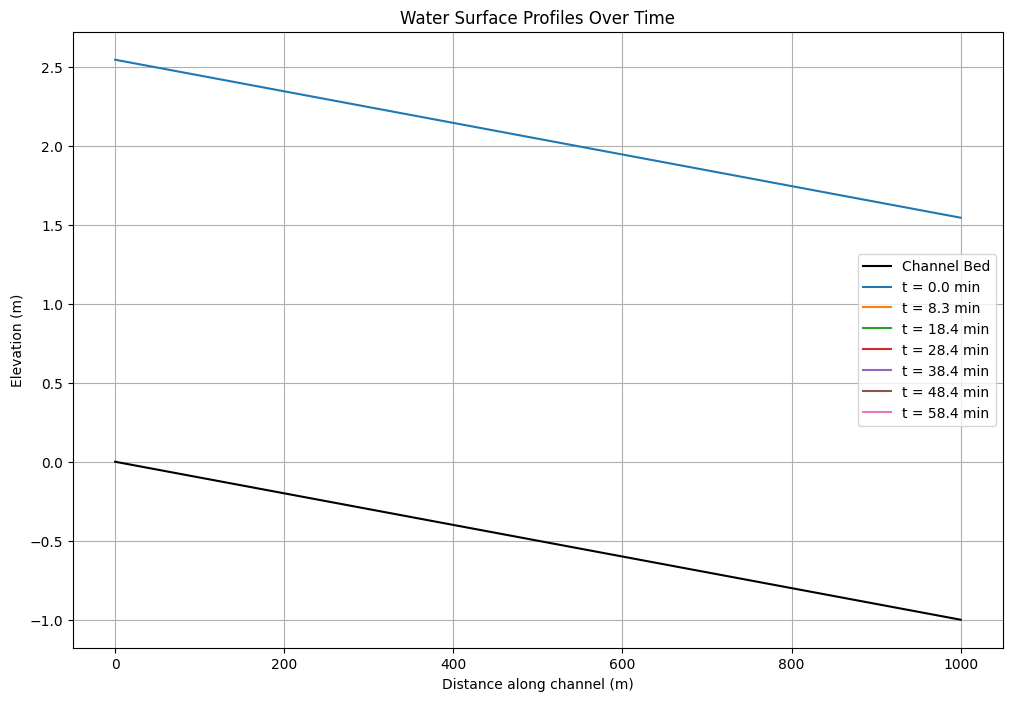

In [5]:
plt.figure(figsize=(12, 8))

# Plot bed elevation
bed_elevation = -S0 * x
plt.plot(x, bed_elevation, 'k-', label='Channel Bed')

# Plot water surface elevation at different times
for i, t_plot in enumerate(t_results):
    if i % (len(t_results) // 6) == 0 or i == len(t_results) - 1: # Plot about 6 profiles
        water_surface_elevation = h_results[i] + bed_elevation
        plt.plot(x, water_surface_elevation, label=f't = {t_plot/60:.1f} min')

plt.title('Water Surface Profiles Over Time')
plt.xlabel('Distance along channel (m)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.grid(True)
plt.show()

**Interpretation:** You should see an initial straight water surface profile (uniform flow). As time progresses, a "drawdown curve" develops from the downstream end and propagates upstream. This is the hydraulic response to the lowering of the downstream water level.

#### 4.2 Hydrographs at Different Locations

This plot shows how the discharge ($Q$) changes over time at specific points along the channel.

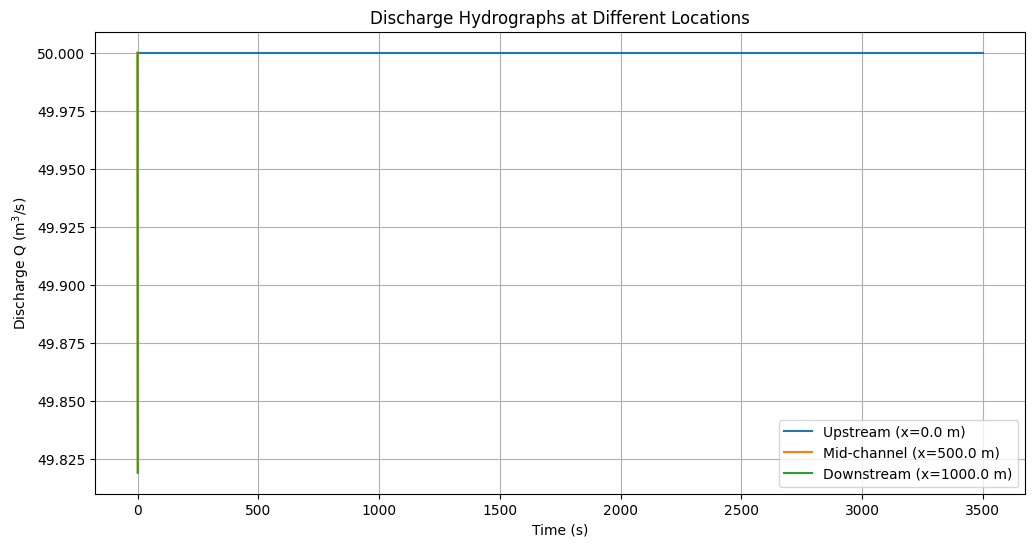

In [6]:
# Extract Q at specific locations
Q_upstream = [q[0] for q in Q_results]
Q_midstream = [q[Nx // 2] for q in Q_results]
Q_downstream = [q[-1] for q in Q_results]

plt.figure(figsize=(12, 6))
plt.plot(t_results, Q_upstream, label=f'Upstream (x={x[0]} m)')
plt.plot(t_results, Q_midstream, label=f'Mid-channel (x={x[Nx//2]} m)')
plt.plot(t_results, Q_downstream, label=f'Downstream (x={x[-1]} m)')

plt.title('Discharge Hydrographs at Different Locations')
plt.xlabel('Time (s)')
plt.ylabel('Discharge Q (m$^3$/s)')
plt.legend()
plt.grid(True)
plt.show()

**Interpretation:** The upstream discharge remains constant because we defined it as our boundary condition. The mid-channel and downstream discharges increase over time. Why? Because the lowering of the water level (and thus a steeper water surface slope) allows the channel to convey more flow. The wave of this change takes time to travel from the downstream end to the middle of the channel, which is why the `Q_midstream` curve responds later than the `Q_downstream` curve.

#### 4.3 (Bonus) Animation of the Water Surface Profile

An animation provides an intuitive feel for the channel dynamics.

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
bed_elevation = -S0 * x
ax.plot(x, bed_elevation, 'k', label='Channel Bed')
line, = ax.plot([], [], 'b', label='Water Surface')
ax.set_xlim(0, L)
ax.set_ylim(np.min(bed_elevation) - 0.5, np.max(bed_elevation + h_normal) + 1.0)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Water Surface Evolution')
ax.legend()
ax.grid(True)
time_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def animate(i):
    wse = h_results[i] + bed_elevation
    line.set_data(x, wse)
    time_text.set_text(f'Time = {t_results[i]/60:.1f} min')
    return line, time_text

# Create animation
# Note: This can be slow. We'll use a subset of frames.
frame_skip = 1 # Use 1 to render all frames, increase to speed up
anim = FuncAnimation(fig, animate, frames=len(h_results[::frame_skip]), interval=50, blit=True)

# Display the animation in the notebook
plt.close(fig) # Prevent static plot from showing
HTML(anim.to_jshtml())

### 5. Discussion and Further Exploration

Congratulations! You have successfully built a 1D hydraulic model. 

**Key Takeaways:**
- The behavior of a river or channel is governed by fundamental physical laws, which can be expressed as the St. Venant equations.
- Numerical methods like the MacCormack scheme allow us to approximate solutions to these complex equations.
- Boundary conditions are crucial; they define the problem we are solving and drive the dynamics of the system.
- Stability (e.g., the CFL condition) is a critical concept in numerical modeling that links the physics of the problem to the numerical grid.

**Ideas for Further Exploration:**
1.  **Change the Boundary Conditions:** What happens if you simulate a flood wave by specifying a time-varying hydrograph at the upstream boundary?
2.  **Change Channel Geometry:** Modify the code to handle a trapezoidal channel instead of a rectangular one. This will require changing the functions that calculate Area ($A$), Wetted Perimeter ($P$), and the pressure term ($gA\bar{y}$).
3.  **Implement a Different Scheme:** Try implementing a simpler (but less accurate) scheme like the Lax-Friedrichs method.
4.  **Dam Break Problem:** A classic hydraulics problem. Start with a reservoir of water behind a dam (high $h$ on one side, low $h$ on the other) and simulate what happens when the dam is removed. This is more challenging as it involves a shock (a steep, moving wave front).